In [12]:
import pandas as pd
import torch
import numpy as np
import ast
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from transformers import BertTokenizer, BertModel
from nltk.cluster import KMeansClusterer, cosine_distance
import nltk
from torch import cdist
from sklearn.manifold import TSNE
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import umap
from transformers import LongformerModel, LongformerTokenizer
import plotly.express as px
import os 
import re
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализируем токенизатор и модель и перемещаем модель на GPU
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerModel.from_pretrained("allenai/longformer-base-4096").to(device)

folder_path = 'C:/Users/andre/Documents/docs'

base_df = pd.DataFrame()
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            paragraphs = [paragraph.strip() for paragraph in re.split(r'\n\s*\n', text) if paragraph.strip()]
            orfr = []
            prfr = []
            fln = []
            for frag in paragraphs:
                # Токенизация и перемещение входных данных на GPU
                inputs = tokenizer(frag, return_tensors="pt", truncation=True, max_length=4096).to(device)
                with torch.no_grad():
                    outputs = model(**inputs)
                # Извлекаем эмбеддинги и вычисляем усреднённый эмбеддинг на GPU
                embeddings = outputs.last_hidden_state
                sentence_embedding = embeddings.mean(dim=1)

                orfr.append(frag)
                prfr.append(sentence_embedding.cpu().numpy())  # Перемещаем обратно на CPU для сохранения
                fln.append(filename)

            df = pd.DataFrame(data={'original fragment': orfr, 'processed fragment': prfr, 'file name': fln})
            print(len(orfr), '= num fragments')
            base_df = pd.concat([base_df, df], axis=0).reset_index(drop=True)
            print(f'file {filename} is processed')

Input ids are automatically padded to be a multiple of `config.attention_window`: 512


17 = num fragments
file В целях обеспечения технологической.txt is processed
9 = num fragments
file В целях обеспечения ускоренного раз.txt is processed
19 = num fragments
file В целях усиления роли науки и техно.txt is processed
8 = num fragments
file Внутриотраслевые приоритеты в рамка.txt is processed
219 = num fragments
file Государственная программа Российско.txt is processed
1 = num fragments
file ДОЛГОСРОЧНАЯ ПРОГРАММА.txt is processed
1 = num fragments
file К О Н Ц Е П Ц И Я развития водородн.txt is processed
5 = num fragments
file Комплексная программа инновационног.txt is processed
2 = num fragments
file Концепция технологического развития.txt is processed
235 = num fragments
file О системе управления реализацией национальной программы.txt is processed
7 = num fragments
file О Стратегии научно-технологического.txt is processed
58 = num fragments
file Об утверждении приоритетных направл.txt is processed
36 = num fragments
file Перечень поручений по вопросам разв.txt is process

In [4]:
X = np.array(base_df['processed fragment'].tolist()).squeeze()
print(X.shape)
NUM_CLUSTERS = 8
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=cosine_distance, repeats=25, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

base_df['cluster'] = pd.Series(assigned_clusters, index=base_df.index)
base_df['centroid'] = base_df['cluster'].apply(lambda x: kclusterer.means()[x])



(4359, 768)


C:\Users\andre\PycharmProjects\pythonProject5\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


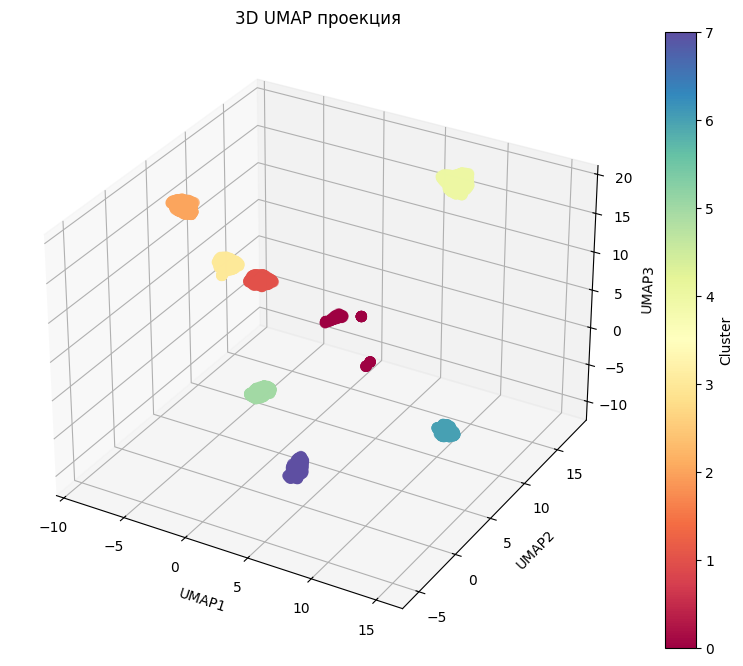

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, assigned_clusters, test_size=0.33, random_state=42)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
embedding = reducer.fit_transform(X_train, y=y_train)

# 3D-визуализация контроль+обучающая выборка
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], 
                     c=y_train, cmap='Spectral', s=50)
ax.set_title('3D UMAP проекция')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()


C:\Users\andre\PycharmProjects\pythonProject5\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


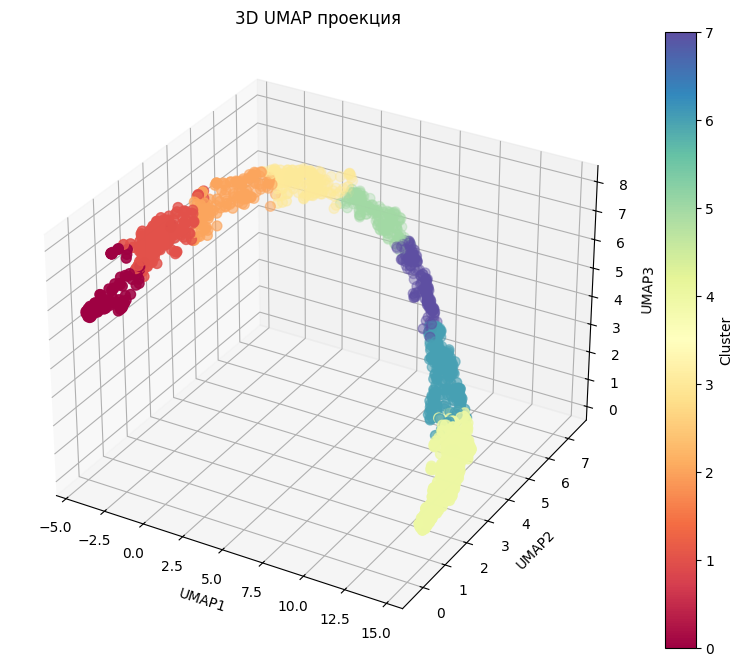

In [6]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
embedding = reducer.fit_transform(X_test)

# 3D-визуализация без контроля+тестовая выборка
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], 
                     c=y_test, cmap='Spectral', s=50)
ax.set_title('3D UMAP проекция')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()


In [7]:
print(X.shape)

(4359, 768)


In [11]:
print(base_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4359 entries, 0 to 4358
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   original fragment   4359 non-null   object
 1   processed fragment  4359 non-null   object
 2   file name           4359 non-null   object
 3   cluster             4359 non-null   int64 
 4   centroid            4359 non-null   object
dtypes: int64(1), object(4)
memory usage: 170.4+ KB
None


In [13]:
def distance_from_centroid(row):
    # Преобразуем в двумерные массивы
    fragment = np.array(row['processed fragment']).reshape(1, -1)
    centroid = np.array(row['centroid']).reshape(1, -1)

    # Вычисляем расстояние
    return cdist(fragment, centroid, metric='euclidean')[0][0]

# Применяем функцию к DataFrame
base_df['distance_from_centroid'] = base_df.apply(distance_from_centroid, axis=1)

In [14]:
print(base_df['distance_from_centroid'])

0       0.723819
1       1.799504
2       0.441925
3       0.597987
4       1.144069
          ...   
4354    0.438302
4355    0.386108
4356    0.365628
4357    0.396486
4358    0.828302
Name: distance_from_centroid, Length: 4359, dtype: float64


In [ ]:
base_df.info()

In [15]:
new_df = base_df[['original fragment', 'cluster','distance_from_centroid', 'file name']]
new_df.to_excel('kmeansdata18_11.xlsx', index=False)